## Initializing opencv haarcascade face detection network
https://github.com/opencv/opencv/tree/master/data/haarcascades
explained in: https://www.youtube.com/watch?v=7IFhsbfby9s&t=300s (or gitHub)

In [1]:
import cv2
import os

In [2]:
def convertImg(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def faceNetLocalize(img, **kwargs):
    scaleFactor = kwargs.get('scaleFactor', 1.1) #between 1.05 (quality) and 1.4 (speed) recommended (scale of the faces we search for)
    minNeighbors = kwargs.get('minNeighbors', 4) #between 3 (quantity) and 6 (quality) recommended
    minSize = kwargs.get('minSize', (10, 10)) #min size of a face in the picture
    faceNet = kwargs.get('faceNet', init_faceNet())
    
    img_cvt = convertImg(img)
    return faceNet.detectMultiScale3(img_cvt, scaleFactor=scaleFactor, minNeighbors=minNeighbors, minSize=minSize, outputRejectLevels = True)

def init_faceNet(**kwargs):
    path = kwargs.get('path', 'haarcascade_frontalface_default.xml')
    return cv2.CascadeClassifier(path)


In [3]:
#TODO: testing with different model types
#for example: eye model + larger bounding box towards the bottom

## Mask classifier

foundation: https://www.tensorflow.org/tutorials/load_data/images

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MaxPool2D, Conv2D, Input, Dense, Flatten, AveragePooling2D, Dropout
import tensorflow.keras.layers as lays
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomContrast, RandomFlip, RandomRotation
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, losses as lfs
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils

#### Data augmentation
https://www.tensorflow.org/tutorials/images/data_augmentation

In [5]:
augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.4),
  RandomContrast(0.5)
])

2022-01-25 02:56:54.006016: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-25 02:56:54.009653: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-25 02:56:54.037761: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


##### variables:

In [6]:
batch_size = 32
img_size = (150, 150)
img_size_vgg = (224, 224)
epochs = 11
checkpoint_path = "mask_model/weights.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
imgs_path = os.path.join('..', 'img')
num_classes = 3

correct_usage =  'correct usage: \n' + 'predict([path to image], \'category\' \n' + 'predict([path to image], \'probabilities\' \n' + 'predict([path to image], \'detection\' \n' + 'predict(\'live_detection\')'

##### loading dataset:

In [7]:
def load_dataset(**kwargs):
    imgs_path = kwargs.get('imgs_path', os.path.join('..', 'img'))
    img_size = kwargs.get('img_size', (180, 180))
    batch_size = kwargs.get('batch_size', 32)

    ##load images/ labels from directory
    valid_images = [".jpg",".png",".jpeg",".JPG"]
    x=[]
    y=[]
    
    for root, dirs, files in os.walk(imgs_path):
        for filename in files:
            end = os.path.splitext(filename)[1]
            if end.lower() not in valid_images:
                continue
            image = load_img(os.path.join(root, filename), target_size=img_size)
            image = img_to_array(image)
            
            label = os.path.join(root, filename).split(os.path.sep)[-2]
            
            x.append(image)
            y.append(label)
    x = np.array(x, dtype="float32")
    y = np.array(y)

    ## convert labels to ints from 0 ... len(labels)-1
    labels = []
    for i in range(len(y)):
        try:
            j = labels.index(y[i])
        except:
            labels.append(y[i])
            j = labels.index(y[i])
        y[i] = j
    y.astype(int)
    
    ## split dataset
    trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=3)

    ## one-hot encoding
    trainY = utils.to_categorical(trainY, num_classes)
    testY = utils.to_categorical(testY, num_classes)

    ## data augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    ## merge xs and ys
    train_batches = datagen.flow(trainX, trainY, batch_size=32, subset='training')
    test_batches  = datagen.flow(trainX, trainY, batch_size=32, subset='validation')
    
    return train_batches, test_batches, labels, testX, testY, trainX, trainY

### Model selection & Training

In [8]:
#Hypermodels
#https://www.analyticsvidhya.com/blog/2021/06/create-convolutional-neural-network-model-and-optimize-using-keras-tuner-deep-learning/
#https://www.tensorflow.org/tutorials/keras/keras_tuner

def basic_model_builder(hp):
  
    basic_model = Sequential([
        Conv2D(filters=hp.Int('c1_filter', min_value=32, max_value=256, step=16), kernel_size=hp.Choice('c1_kernel', values=[3,5]), activation='relu'),
        AveragePooling2D(pool_size=(7,7)),
        Flatten(name="flatten"),
        Dense(units=hp.Int('d1_units', min_value=32, max_value=512, step=32), activation="relu"),
        Dropout(0.2),#drops small confidences
        Dense(num_classes, activation="softmax")
    ])

    basic_model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss=lfs.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return basic_model

def small_model_builder(hp):
  
    small_model = Sequential([
        Conv2D(filters=hp.Int('c1_filter', min_value=32, max_value=256, step=16), kernel_size=hp.Choice('c1_kernel', values=[3,5]), activation='relu'),
        Conv2D(filters=hp.Int('c2_filter', min_value=32, max_value=256, step=16), kernel_size=hp.Choice('c2_kernel', values=[3,5]), activation='relu'),
        MaxPool2D(pool_size=(3,3)),
        Flatten(name="flatten"),
        Dense(units=hp.Int('d1_units', min_value=32, max_value=512, step=32), activation="relu"),
        Dropout(0.2),#drops small confidences
        Dense(num_classes, activation="softmax")
    ])

    small_model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss=lfs.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return small_model


def tune_model(model_builder, xs, ys):
    #tuner = kt.RandomSearch(model_builder, objective='val_accuracy', max_trials=5)
    tuner = kt.RandomSearch(kt.applications.HyperResNet(input_shape=(180, 180, 3), classes=2), objective='val_loss', max_trials=5)
    tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3)
    tuner.search(xs, ys, epochs=50, validation_split=0.2)
    return tuner.get_best_hyperparameters(num_trials=1)[0], tuner

In [9]:

def select_model(model_name, **kwargs):
    num_labels = kwargs.get('num_classes', num_classes)

    basic_model = Sequential()
    basic_model.add(Conv2D(32, (3,3), activation='relu', input_shape=(180,180,3)))
    basic_model.add(AveragePooling2D(pool_size=(7,7)))
    basic_model.add(Flatten(name="flatten"))
    basic_model.add(Dense(128, activation="relu"))
    basic_model.add(Dropout(0.5)) #drops small confidences
    basic_model.add(Dense(num_labels, activation="softmax"))
    

    small_model = Sequential()
    small_model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu', input_shape=(180,180,3)))
    small_model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
    small_model.add(MaxPool2D(pool_size=(3,3)))
    small_model.add(Flatten(name="flatten"))
    small_model.add(Dense(units=224, activation="relu"))
    small_model.add(Dropout(0.5))#drops small confidences
    small_model.add(Dense(num_labels, activation="softmax"))
    
    vgg_smaller_model=Sequential()
    vgg_smaller_model.add(Conv2D(64,(3,3),activation='relu',input_shape=(180,180,3)))
    vgg_smaller_model.add(MaxPool2D(2,2))
    vgg_smaller_model.add(Conv2D(128,(3,3),activation='relu'))
    vgg_smaller_model.add(MaxPool2D(2,2))
    vgg_smaller_model.add(Flatten())
    vgg_smaller_model.add(Dropout(0.5))
    vgg_smaller_model.add(Dense(120,activation='relu'))
    vgg_smaller_model.add(Dense(num_labels,activation='softmax'))
    

    vgg_small_model=Sequential()
    vgg_small_model.add(Conv2D(64,(3,3),activation='relu',input_shape=(img_size[0],img_size[1],3)))
    vgg_small_model.add(MaxPool2D(2,2))
    vgg_small_model.add(Conv2D(64,(3,3),activation='relu'))
    vgg_small_model.add(MaxPool2D(2,2))
    vgg_small_model.add(Conv2D(128,(3,3),activation='relu'))
    vgg_small_model.add(MaxPool2D(2,2))
    vgg_small_model.add(Conv2D(128,(3,3),activation='relu'))
    vgg_small_model.add(MaxPool2D(2,2))
    vgg_small_model.add(Flatten())
    vgg_small_model.add(Dropout(0.5))
    vgg_small_model.add(Dense(120,activation='relu'))
    vgg_small_model.add(Dense(num_labels,activation='softmax'))

    vgg_smaller_model=Sequential()
    
    vgg_smaller_model.add(Conv2D(64,(3,3),activation='relu',input_shape=(180,180,3)))
    vgg_smaller_model.add(MaxPool2D(2,2))
    vgg_smaller_model.add(Conv2D(128,(3,3),activation='relu'))
    vgg_smaller_model.add(MaxPool2D(2,2))
    vgg_smaller_model.add(Flatten())
    vgg_smaller_model.add(Dropout(0.5))
    vgg_smaller_model.add(Dense(120,activation='relu'))
    vgg_smaller_model.add(Dense(3,activation='softmax'))

    vgg_model = Sequential()
    vgg_model.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu", strides=(1,1))) 
    vgg_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    vgg_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    vgg_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(MaxPool2D(pool_size=(2, 2), strides=(2)))
    vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(MaxPool2D(pool_size=(2, 2), strides=(2)))
    vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(MaxPool2D(pool_size=(2, 2), strides=(2)))
    vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    vgg_model.add(MaxPool2D(pool_size=(2, 2), strides=(2)))
    vgg_model.add(Flatten())
    vgg_model.add(Dense(units=4096, activation="relu"))
    vgg_model.add(Dense(units=4096, activation="relu"))
    vgg_model.add(Dense(units=num_labels, activation="softmax"))
    

    if model_name == 'basic_model':
        #basic_model.summary()
        return basic_model
    
    if model_name == 'small_model':
        #small_model.summary()
        return small_model

    if model_name == 'vgg_model':
        #vgg_model.summary()
        return vgg_model
    
    if model_name == 'vgg_small_model':
        vgg_small_model.summary()
        return vgg_small_model
    
    if model_name == 'vgg_smaller_model':
        vgg_smaller_model.summary()
        return vgg_smaller_model

about the VGG-model: https://neurohive.io/en/popular-networks/vgg16/

In [10]:
def train_model(model, train_ds, val_ds, **kwargs):
    epochs = kwargs.get('epochs', 10)
    # categorical_crossentropy
    # mean_squared_error
    # mean_squared_logarithmic_error

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    return history

#### Testing/Evaluation (mask):
https://www.tensorflow.org/guide/keras/train_and_evaluate

In [11]:
def evaluate_model(x_test, y_test, model):
    results = model.evaluate(x_test, y_test, batch_size=32)
    print(results)
    
    y_pred_confidences = model.predict(x_test)
    y_pred = [np.argmax(cs) for cs in y_pred_confidences]
    print(classification_report(y_test, y_pred))

##### Predictions:

In [12]:
def load_model(**kwargs):
    checkpoint_path = kwargs.get('checkpoint_path', "mask_model/weights.ckpt")
    model = kwargs.get('model', select_model('basic_model'))
    model.load_weights(checkpoint_path)
    return model

In [34]:
def maskPredict(model, img, labels):
    pred = model.predict(img[None])
    label_index = np.argmax(pred)
    print(labels[label_index])
    return labels[label_index], pred[0][label_index]


#mode can be 'category', 'probabilities', 'detection', 'live_detection'
def predict(mode, model, **kwargs):
    #model = kwargs.get('model', load_model())
    img_path = kwargs.get('img_path', None)
    img_size = kwargs.get('img_size', (180, 180))
    labels = kwargs.get('labels', None)
    
    
    if mode=='live_detection':
        live_det(model, img_size, labels)
        return
    
    if img_path is None:
        print(correct_usage)
        return

    #load_img
    img = load_img(img_path, target_size = img_size)
    img = img_to_array(img)
    
    if mode=='detection':
        detect(img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        return
        
    if mode=='category':
        label, confidence = maskPredict(model, img, labels)
        return label
        
    if mode=='probabilities':
        #TODO: schöneres Format
        return model.predict(img[None])

    else:
        print(correct_usage)

def detect(model, img, img_size, labels):
    faceLocs, rejectLevels, confidences = faceNetLocalize(img)
        
    for (x, y, w, h) in faceLocs:
        #crop image and predict label of cropped image
        img_crop = img[y:y+w, x:x+h]
        img_crop = cv2.resize(img_crop, img_size)
        img_crop = img_crop / 255
        label, confidence_mask = maskPredict(model, img_to_array(img_crop), labels)

        #show label/ bounding box on image
        cv2.putText(img, f"{label}, confidence:{confidence_mask}", (x, y), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 2) 
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)
    
    cv2.imshow('live_output', img)

def live_det(model, img_size, labels):
    wait_time = 10 #time in ms to wait before refreshing feed
    camera = cv2.VideoCapture(0) #Input value might differ on different systems
    
    while(True):
        ret, img = camera.read()
        if not ret:
            print('Error: failed reading camera')
            return 'Error: failed reading camera'
        detect(model, img, img_size, labels)

        #wait for ESC or q
        if (cv2.waitKey(wait_time) & 0xFF) in [27, ord('q')]: 
            break

    camera.release()
    return 'live_output'



In [14]:
train_ds, test_ds, labels, testX, testY, trainX, trainY = load_dataset(img_size=img_size)
#bhps, tuner = tune_model(basic_model_builder, x_test, y_test)

In [15]:
model = select_model('vgg_small_model')
#model = tuner.hypermodel.build(bhps)
history = train_model(model, train_ds, test_ds, epochs=35)

#evaluate_model(testX, testY, model)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

/home/lzirus/miniconda3/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/lzirus/miniconda3/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
2022-01-25 02:57:17.386364: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-25 02:57:17.434043: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2111995000 Hz


Epoch 1/35
8/8 [==============================] - 15s 1s/step - loss: 0.2296 - accuracy: 0.3695 - val_loss: 0.2112 - val_accuracy: 0.4839
Epoch 2/35
8/8 [==============================] - 12s 2s/step - loss: 0.2174 - accuracy: 0.4173 - val_loss: 0.1874 - val_accuracy: 0.6452
Epoch 3/35
8/8 [==============================] - 12s 1s/step - loss: 0.1755 - accuracy: 0.5631 - val_loss: 0.1243 - val_accuracy: 0.7903
Epoch 4/35
8/8 [==============================] - 12s 2s/step - loss: 0.1356 - accuracy: 0.6529 - val_loss: 0.1769 - val_accuracy: 0.5323
Epoch 5/35
8/8 [==============================] - 11s 1s/step - loss: 0.1354 - accuracy: 0.7058 - val_loss: 0.1250 - val_accuracy: 0.6935
Epoch 6/35
8/8 [==============================] - 12s 2s/step - loss: 0.1027 - accuracy: 0.7551 - val_loss: 0.0914 - val_accuracy: 0.8548
Epoch 7/35
8/8 [==============================] - 11s 1s/step - loss: 0.0961 - accuracy: 0.8217 - val_loss: 0.0796 - val_accuracy: 0.8065
Epoch 8/35
8/8 [==================

In [16]:
print("loss =",history.history["loss"])
print("val_loss =",history.history["val_loss"])
print("acc =",history.history["accuracy"])
print("val_acc =",history.history["val_accuracy"])

[0.4838709533214569, 0.6451612710952759, 0.7903226017951965, 0.5322580933570862, 0.6935483813285828, 0.8548387289047241, 0.8064516186714172, 0.774193525314331, 0.8225806355476379, 0.9032257795333862, 0.9032257795333862, 0.8870967626571655, 0.9032257795333862, 0.8870967626571655, 0.9354838728904724, 0.8709677457809448, 0.9193548560142517, 0.9193548560142517, 0.9032257795333862, 0.8709677457809448, 0.8709677457809448, 0.8548387289047241, 0.8709677457809448, 0.8548387289047241, 0.8225806355476379, 0.9032257795333862, 0.9193548560142517, 0.8709677457809448, 0.9032257795333862, 0.9193548560142517, 0.9032257795333862, 0.9032257795333862, 0.9193548560142517, 0.9032257795333862, 0.9032257795333862]


In [ ]:
print("loss =",history.history["loss"])
print("val_loss =",history.history["val_loss"])
print("acc =",history.history["accuracy"])
print("val_acc =",history.history["val_accuracy"])

loss = [0.22497519850730896, 0.21416635811328888, 0.1636561155319214, 0.13210934400558472, 0.12020868062973022, 0.10055090487003326, 0.09672383964061737, 0.07640034705400467, 0.09279493987560272, 0.06421622633934021, 0.0856298953294754, 0.06610191613435745, 0.06236286088824272, 0.06685104966163635, 0.061523545533418655, 0.060288019478321075, 0.059381090104579926, 0.04825696721673012, 0.04491526633501053, 0.050940174609422684, 0.05237959325313568, 0.040814872831106186, 0.06189798191189766, 0.08095339685678482, 0.06303732842206955, 0.06036676838994026, 0.10113377124071121, 0.07260239869356155, 0.05840269476175308, 0.046509772539138794, 0.05326557531952858, 0.03870682045817375, 0.034509725868701935, 0.04216747358441353, 0.04051816463470459]
val_loss = [0.21122969686985016, 0.18737666308879852, 0.1243443489074707, 0.17690889537334442, 0.12504221498966217, 0.09137201309204102, 0.07957252115011215, 0.09069792181253433, 0.0767928808927536, 0.05703876540064812, 0.05404513701796532, 0.055348712

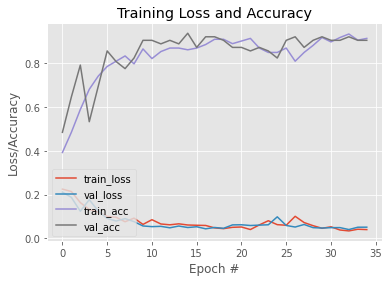

In [19]:
N = 35
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [37]:
img_path='../img/ffp2/IMG_1599.JPG_(350.0, 92.0, 1009.0, 599.0).png'
#img_path='../img/no_mask/IMG_1323.JPG_(1025, 427, 984, 984).png'
#img_path='../img/op_mask/IMG_1337.JPG_(878, 710, 954, 954).png'
#img_path='../img/other_mask/IMG_1327.JPG_(863, 476, 1097, 1097).png'
predict('category',img_path=img_path,  model=model, labels=labels, img_size=(180,180))

#predict('live_detection', model=model, labels=labels, img_size=(180,180))

op_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
no_mask
